In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [2]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'

SMOOTH = False

SEED = 25811243



## 1. ETL

In [3]:
from src import spectrumloader as spl
from src import get_torch_loader as tlg
# from src.modeltorch_template import NeuralNet,RamConv1d,RamLSTM,RamConv1d_bnmx,IntANN,IntRamLSTM,RamConv1d_mx
from src import trainResult_show as mtp

In [4]:
standard,data_all = spl.read_file('dataset/')

In [5]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [6]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [7]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [8]:
X_train_VR = spl.fluoresence_removal(X_trainall)
if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)

In [9]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

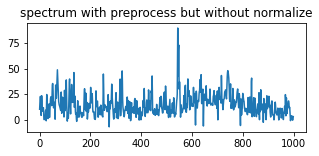

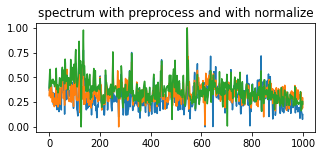

In [10]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

## 5. apply data to pytorch

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))



In [13]:
train_size = 12
val_size = 4
batch_size=12
valbatch_size=4
train_loader_all,val_loader_all = tlg.shuffleloadertorch(ds_earloop,ds_inarm,ds_thumbnail,ds_vain,SEED,train_size,val_size,batch_size,valbatch_size)

## 6. modeling
- ### 6.simple
    - ### ANN
# Template to Run ANN model
- ### to use change the model name and try

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()  #super(Model, self)
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [15]:
# EXAMPLE model_for_vain = NeuralNet(1000, 14, 2).to(device) 

model_for_earloop = NeuralNet(1000, 14, 2).to(device)
model_for_inarm = NeuralNet(1000, 14, 2).to(device)
model_for_thumbnail = NeuralNet(1000, 14, 2).to(device)
model_for_vain = NeuralNet(1000, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annsim_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [16]:
annsim_models[0]

NeuralNet(
  (fc1): Linear(in_features=1000, out_features=14, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=14, out_features=2, bias=True)
)

In [17]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000
train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []
for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(annsim_models,annsim_criterions,annsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')

    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0007    ++++++Validation++++++  Loss: 4.83 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.1045    ++++++Validation++++++  Loss: 1.97 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0301    ++++++Validation++++++  Loss: 0.57 - Acc: 75.00     ++++++Validation++++++  Loss: 0.48 - Acc: 100.00     ++++++Validation++++++  Loss: 0.48 - Acc: 75.00     ++++++Validation++++++  Loss: 0.54 - Acc: 75.00     ++++++Validation++++++  Loss: 0.55 - Acc: 75.00 
 END OF MODEL for thumb nail with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0844    ++++++Validation++++++  Loss: 4.36 - Acc: 0.00    ++++++Validation++++++  Loss: 1.96 - Acc: 0.00     ++++++Validation++++++  Loss: 2.42 - Acc: 0.00     ++++++Validation++++++  Loss: 3.12 - Acc: 0.00     ++++++Validation++++++  Loss: 3.31 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 

#### loss plot

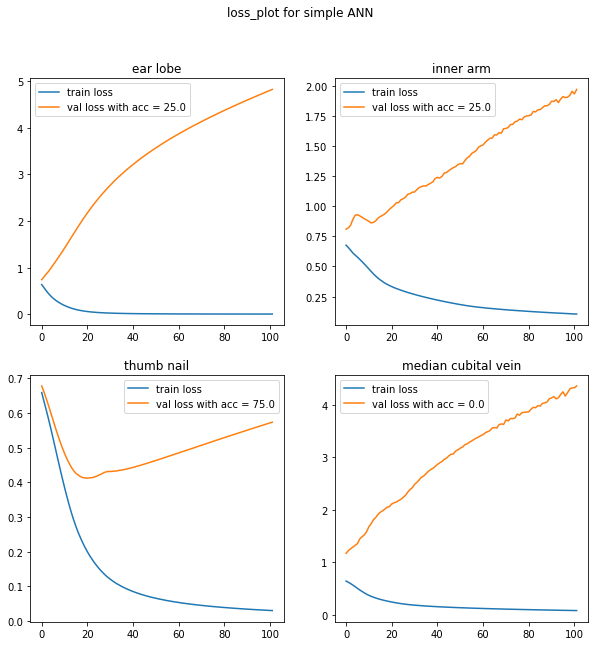

In [18]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple ANN')

- ### 6.simple
    - ### CNN
# Template FOR test your CNN

In [19]:
class RamConv1d_bnmx(nn.Module):
    def __init__(self, input_size = 1, hidden_size=50,hidden_size2=10,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size = 3)      
        self.relu1 = nn.ReLU()                            
        # Convolution Layer 2
        self.conv2 = nn.Conv1d(hidden_size, hidden_size2, kernel_size = 3)     
        self.maxpool1 = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool1d(2)                   
        self.relu2 = nn.ReLU()                           
        # Fully connected layers
        self.fc1 = nn.Linear(2480, linear_hidden)
        self.fc2 = nn.Linear(linear_hidden, out_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size2)
        # self.batchnorm3 = nn.BatchNorm1d(50)
    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                                                    
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x) 
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        # Switch from activation maps to vectors
        # x = x.reshape(-1, 24900)
        # print(x.shape)
        x = x.reshape(x.size(0), -1)
        # print(x.shape)
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu1(x)
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x


In [20]:
# EXAMPLE modelcnn_for_earloop = RamConv1d().to(device)

modelcnn_for_earloop = RamConv1d_bnmx().to(device)
modelcnn_for_inarm = RamConv1d_bnmx().to(device)
modelcnn_for_thumbnail = RamConv1d_bnmx().to(device)
modelcnn_for_vain = RamConv1d_bnmx().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [21]:
cnnsim_models[0]

RamConv1d_bnmx(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(50, 10, kernel_size=(3,), stride=(1,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=2480, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=2, bias=True)
  (batchnorm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [22]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnsim_models,cnnsim_criterions,cnnsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 6.29 - Acc: 0.00     ++++++Validation++++++  Loss: 5.76 - Acc: 0.00 
 END OF MODEL for ear lobe with val acc = 0.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 3.77 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 1.78 - Acc: 50.00     ++++++Validation++++++  Loss: 1.24 - Acc: 50.00     ++++++Validation++++++  Loss: 1.48 - Acc: 50.00 
 END OF MODEL for thumb nail with val acc = 50.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 2.58 - Acc: 25.00     ++++++Validation++++++  Loss: 2.29 - Acc: 25.00 
 END OF MODEL for median cubital vein with val acc = 25.0


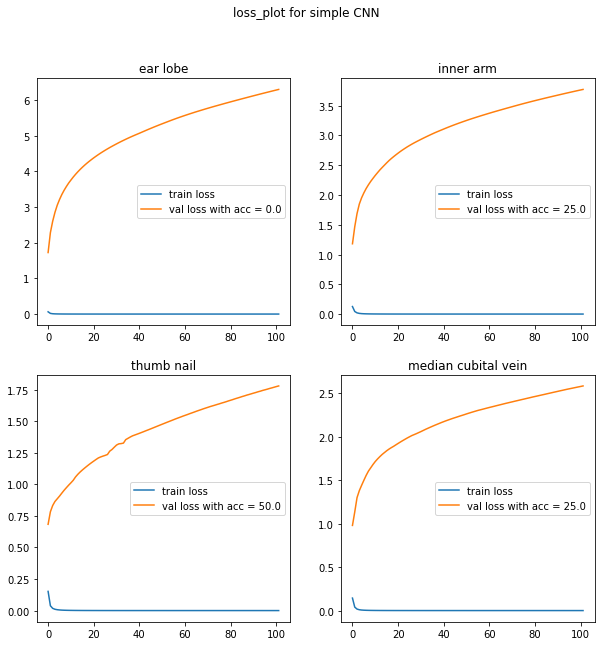

In [23]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',cnnsim_models[-1](spec),'\n',y,'\n val\n',cnnsim_models[-1](val_spec),val_label)

mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple CNN')

- ### 6.simple
    - RNN
- ADD YOUR Try here

In [21]:
from torch.autograd import Variable
class RNNModel(nn.Module):
    def __init__(self, input_size = 1000, hidden_size = 50, layer_size = 50, output_size = 2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.layer_size = layer_size
        
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='relu')
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        
        h0 = Variable(torch.zeros(self.layer_size, x.size(0), self.hidden_size)).to(device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out


In [22]:
# EXAM PLE model_RNN_for_earloop = RamLSTM().to(device)

model_RNN_for_earloop = RNNModel().to(device)
model_RNN_for_inarm = RNNModel().to(device)
model_RNN_for_thumbnail = RNNModel().to(device)
model_RNN_for_vain = RNNModel().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [23]:
simRNN_models[0]

RNNModel(
  (rnn): RNN(1000, 50, num_layers=50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

In [24]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [657/5000], Step [1/1.0], Loss: 0.6792    ++++++Validation++++++  Loss: 0.79 - Acc: 25.00 

KeyboardInterrupt: 

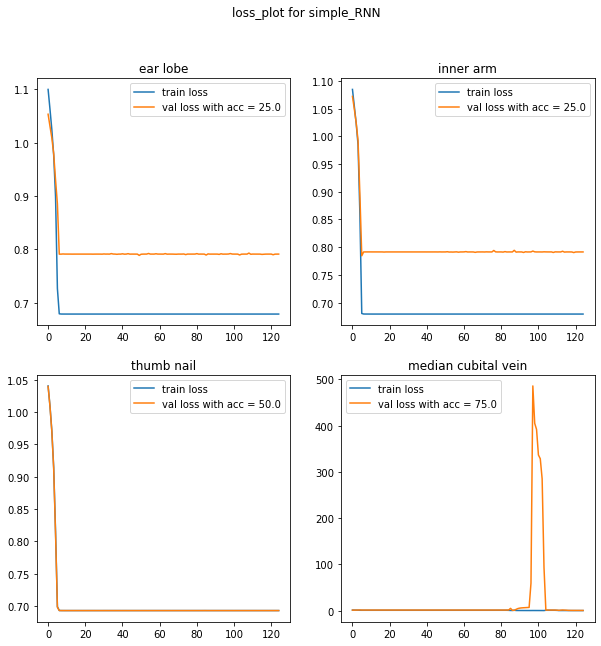

In [33]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple_RNN')